In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import japanize_matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

os.chdir("../")

RATE_A = "RateA"
RATE_S = "RateS"
df = pd.read_csv("csv/GReeeeN_20231119.csv")

In [2]:
def preprocess(df, csv_path:str):
    rates = pd.merge(df, pd.read_csv(csv_path), on='song')
    rates = rates.dropna(subset=["numerator_A", "denominator_A", "numerator_S", "denominator_S"])

    rates[RATE_A] = rates.numerator_A / rates.denominator_A
    rates[RATE_S] = rates.numerator_S / rates.denominator_S

    x_max = rates.RateA.max()
    x_min = rates.RateA.min()
    y_max = rates.RateS.max()
    y_min = rates.RateS.min()

    xy_max = max(x_max, y_max)
    xy_max += xy_max / xy_max / 100
    xy_min = min(x_min, y_min)
    xy_min -= xy_min / xy_min / 100

    return (rates, xy_min, xy_max)

In [3]:
def scatter(rates:pd.DataFrame, xy_min:int, xy_max:int, subset:list, sort_by:str, xlabel:str, ylabel:str):
    sorted_rates = rates.dropna(subset=subset).sort_values(sort_by, ascending=False)
    center = len(sorted_rates) // 2
    pop_youtube = sorted_rates[:center]
    unpop_youtube = sorted_rates[center:]

    plt.scatter(x=RATE_A, y=RATE_S, data=pop_youtube, color='blue', label='人気曲')
    plt.scatter(x=RATE_A, y=RATE_S, data=unpop_youtube, color='red', label='普通曲')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.xlim(xy_min, xy_max)
    plt.ylim(xy_min, xy_max)
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle='solid')
    plt.grid(which='minor', color='lightgray', linestyle='dotted')

# 単語の一致率

In [4]:
rates_wmr, xy_min_wmr, xy_max_wmr = preprocess(df, "csv/GReeeeN_wmr_20231119.csv")

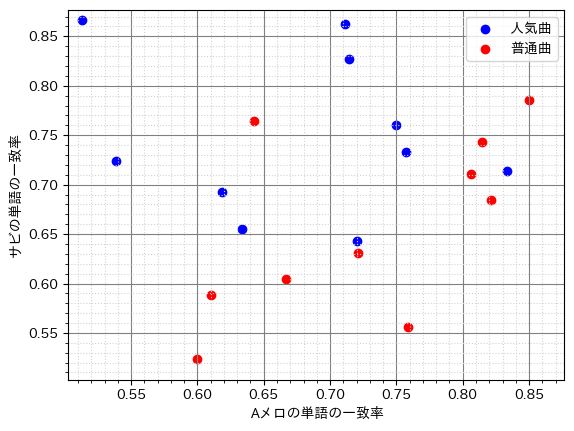

In [5]:
scatter(rates_wmr, xy_min_wmr, xy_max_wmr, ["youtube_url"], "youtube_play_times", "Aメロの単語の一致率", "サビの単語の一致率")

## t検定(サビ，軸回転なし)
- 帰無仮説：サビの単語の一致率の平均は等しい
- 有意水準：0.05

In [6]:
sorted_rates = rates_wmr.dropna(subset=["youtube_url"]).sort_values("youtube_play_times", ascending=False)
center = len(sorted_rates) // 2
pop_youtube = sorted_rates[:center]
unpop_youtube = sorted_rates[center:]

stats.ttest_ind(pop_youtube[RATE_S], unpop_youtube[RATE_S], equal_var=False)

TtestResult(statistic=2.3042795060515795, pvalue=0.0335469401057381, df=17.711709598517377)

## 座標軸の回転

In [7]:
import math
import numpy as np

def rotate(x, y, theta):
    xy_mat = np.matrix([[x], [y]])
    mat = np.matrix([
        [math.cos(math.radians(theta)), -1 * math.sin(math.radians(theta))],
        [math.sin(math.radians(theta)), math.cos(math.radians(theta))]
    ])
    return np.dot(mat, xy_mat)

In [8]:
for i in range(0, len(rates_wmr[RATE_A])):
    nxy = rotate(rates_wmr[RATE_A][i], rates_wmr[RATE_S][i], -45)
    rates_wmr.at[i, RATE_A] = nxy[0, 0]
    rates_wmr.at[i, RATE_S] = nxy[1, 0]

In [9]:
sorted_rates = rates_wmr.dropna(subset=["youtube_url"]).sort_values("youtube_play_times", ascending=False)
center = len(sorted_rates) // 2
pop_youtube = sorted_rates[:center]
unpop_youtube = sorted_rates[center:]

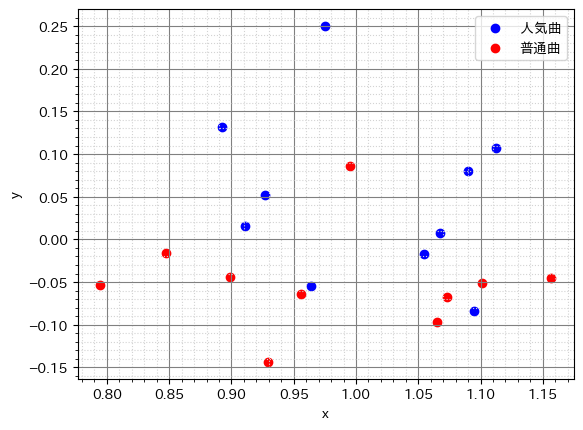

In [10]:
plt.scatter(x=RATE_A, y=RATE_S, data=pop_youtube, color='blue', label='人気曲')
plt.scatter(x=RATE_A, y=RATE_S, data=unpop_youtube, color='red', label='普通曲')

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='solid')
plt.grid(which='minor', color='lightgray', linestyle='dotted')

## t検定(45度回転)
- 帰無仮説：座標軸を45度回転したときのサビの単語の一致率の平均値は人気曲と普通曲で等しい
- 対立仮説：座標軸を45度回転したときのサビの単語の一致率の平均値は人気曲と普通曲で差がある
- 有意水準：0.05

In [11]:
stats.ttest_ind(pop_youtube[RATE_S], unpop_youtube[RATE_S], equal_var=False)

TtestResult(statistic=2.7089414589748353, pvalue=0.016377681442008546, df=14.717118413874488)

- p値が有意水準0.05を下回ったため、帰無仮説を棄却する。
- GReeeeNにおいて人気曲と普通曲とでは有意差があると言える

# 木構造の類似度計算（親子）

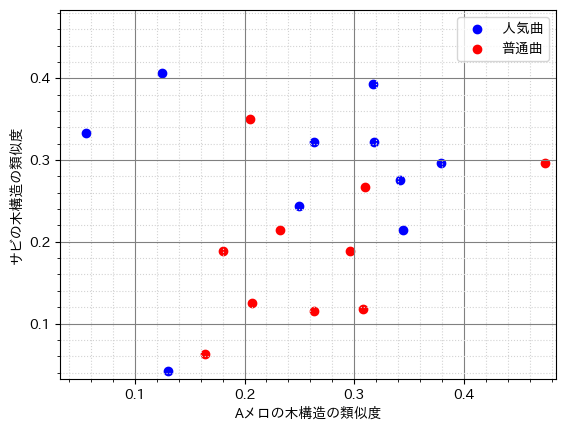

In [12]:
rates_ts, xy_min_tspc, xy_max_tspc = preprocess(df, "csv/GReeeeN_tspc_20231119.csv")
scatter(rates_ts, xy_min_tspc, xy_max_tspc, ["youtube_url"], "youtube_play_times", "Aメロの木構造の類似度", "サビの木構造の類似度")

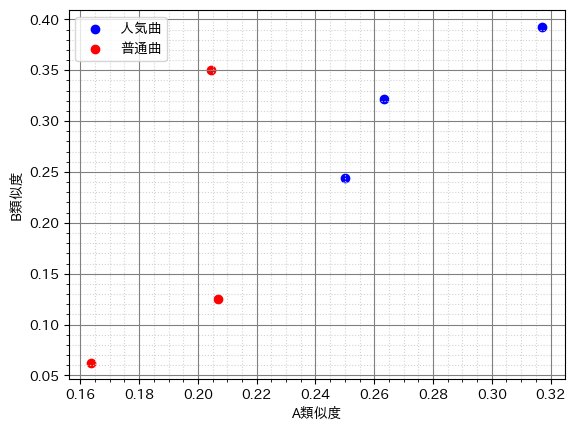

In [15]:
sorted_rates = rates_ts.dropna(subset=["youtube_url"]).sort_values("youtube_play_times", ascending=False)
plt.scatter(x=RATE_A, y=RATE_S, data=sorted_rates.head(3), color='blue', label='人気曲')
plt.scatter(x=RATE_A, y=RATE_S, data=sorted_rates.tail(3), color='red', label='普通曲')

plt.xlabel("A類似度")
plt.ylabel("B類似度")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='solid')
plt.grid(which='minor', color='lightgray', linestyle='dotted')

## t検定(サビ，軸回転なし)
- 帰無仮説：サビの単語の一致率の平均は等しい
- 有意水準：0.05

In [13]:
sorted_rates = rates_ts.dropna(subset=["youtube_url"]).sort_values("youtube_play_times", ascending=False)
center = len(sorted_rates) // 2
pop_youtube = sorted_rates[:center]
unpop_youtube = sorted_rates[center:]

stats.ttest_ind(pop_youtube[RATE_S], unpop_youtube[RATE_S], equal_var=False)

TtestResult(statistic=2.107421138570833, pvalue=0.04962899679596903, df=17.684812768440647)